# Home assigment 2

Please give your name below:

In [ ]:
name=''

## Exercise 2

Now you will put together the pieces you learnt in previous labs in order to write a continuous energy Monte Carlo particle transport simulation of a Uranium sphere! Your goal is to estimate the k-effective and to try to find the critical radius of a U-235 sphere. 

Your assumptions:

- The geometry is a sphere
- The sphere is made of pure U-235.
- You only care about the following reactions: capture, fission and elastic scattering 
- All scattering is isotropic in the CM frame.
- Neutrons emerge isotropically from fission.
- You received the pointwise cross sections and the energy dependent nubar data in the /data folder.
- You can neglect that in a fission event the number of generated neutrons is stochastic, and assume that always nubar neutrons are created.
- For the prompt neutron energies you can sample the Watt-distribution (see lecture notes, or Datalab 4)
- You do not need to track time (thus all neutrons can be considered to be prompt)
- Initially launch neutrons from the center of the sphere, then store fission sites, and later sample the new fission sites from this "bank".

Your tasks:

1. Plot the the cross section data and the nubar data.
2. Complete the support functions given below and the function `run()` in order to estimate the k-eigenvalue of a sphere with a continous energy 3D Monte Carlo particle transport simulation. The support functions are the ones which you saw in Datalab 5b (for example the direction transformations, elastic scattering etc.). Some of these functions you will need to update (eg. for the reaction type sampler, include fission). You can include other input parameters and set default values if you feel needed. For each neutron generation estimate the k-eigenvalue based on the initial number of neutrons and the new neutrons after the generation (as we did in Datalab 5a).
3. Modify the return list in order to return and plot other data
    - Plot the k-eigenvalue estimate vs the generation number
    - Plot how the estimated mean k-eigenvalue converges. (use such figures to argue about reasonable values for `NGEN`, `NPG`, `NSKIP`). 
4. Investigate how the k-eigenvalue depends on the radius of the sphere. Visualize this with matplotlib.
5. Find the critical radius. You can do this either with manual trial and error, or use an optimization method.


Hints: in this exercise you have to merge your knowledge from datalab 5a (ie. batchwise estimation of k-effective) and from datalab 5b (ie. tracking neutrons). If you are not sure about the validity of your results you can compare your findings with the values of critical radii from [Wikipedia](https://en.wikipedia.org/wiki/Critical_mass). Try to have similar order of magnitude results.

To be fair, in a real MC criticality calculation, the initial number of neutrons per cycle also fluctuates, and the k-eigenvalue is calculated with some power iteration. In that case some care needs to be taken to renormalize the number of events to be placed in the bank, in order to have more or less the same amount of starting neutrons in each batch, otherwise sub and supercritical systems would be problematic to be simulated (here p200-225 gives some details on that: https://mcnp.lanl.gov/pdf_files/la-ur-16-29043.pdf). You don't need to worry about these. We are satisfied with a simpler approach. Rather you will initiate the same amount of neutrons in each cycle, regardless how many were produced before, and we place every fission site into the bank, and sample the locations from that. We also do not require an initial guess for the k-eigenvalue (as you can see in the link for the power iteration based method, an initial guess is needed). 

In the first few cycles when we launch neutrons only from the center, we will probably underestimate leakage, so the estimates of $k$ will be biased. Therefore NSKIP just means that the first NSKIP number of cycle estimates of the k-effective should not be taken into account when calculating the mean of the k-effective, since the spatial distribution of the fission source is still biased by our original source location, and not spread yet throughout the geometry. Actually for this simple geometry NSKIP plays a less important role, so if you are not certain about what it is, feel free to ignore it. 

Try not to overcomplicate the exercise. The function `run()` with docstrings and comments can be written in less than 80 lines of code. Below we collected all the supporting functions from Datalab 4 and 5, which you will need to use. Some of them you need to update or finish first. We also loaded the nuclear data.

Also, ideally the computation should not be too slow. Test first with small NGEN and NPG values (eg. 100 for both). This should already provide decent accuracy. I tested that on an older laptop this many batches and particles can be run within a minute without any vectorization. If you experience that your computation is much longer, there might be a mistake.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

Es,xss=np.loadtxt('data/u235el.dat',skiprows=2).transpose()
Ec,xsc=np.loadtxt('data/u235cap.dat',skiprows=2).transpose()
Ef,xsf=np.loadtxt('data/u235fiss.dat',skiprows=2).transpose()

Enu,nubar=np.loadtxt('data/u235nubar.dat',skiprows=2).transpose()


density = 19.1 #g/cm3
A = 235

#TODO : get the macroscopic cross section


##### SUPPORT functions
def distanceToCollision(SigT,N=1):
    x=np.random.uniform(0,1,N)
    return -np.log(x)/SigT

def reactionType(SigS,SigC,SigT):
    #TODO: include the fission cross section!
    x=np.random.uniform(0,1)
    if x < SigS/SigT:
        return 'scatter'
    else:
        return 'capture'

def elasticScatter(E):
    muC=np.random.uniform(-1,1)
    thetaC=np.arccos(muC)
    E=(((1+alpha)+(1-alpha)*muC)/2)*E
    thetaL=np.arctan2(np.sin(thetaC),((1/A)+muC))
    muL=np.cos(thetaL)
    return E, muL

def randomDir():
    mu=np.random.uniform(-1,1)
    theta=np.arccos(mu)
    phi=np.random.uniform(0,2*np.pi)

    u=np.sin(theta)*np.cos(phi)
    v=np.sin(theta)*np.sin(phi)
    w=np.cos(theta)
    return np.array([u,v,w])

def transformDir(u,v,w,mu):
    """
    transform coordinates according to openMC documentation.
    
    Parameters
    ----------
    u : float
        Old x-direction
    v : float
        Old y-direction
    w : float
        Old z-direction
    mu : float
        Lab cosine of scattering angle
    """
    phi=np.random.uniform(0,2*np.pi)
    un=mu*u+(np.sqrt(1-mu**2)*(u*w*np.cos(phi)-v*np.sin(phi)))/(np.sqrt(1-w**2))
    vn=mu*v+(np.sqrt(1-mu**2)*(v*w*np.cos(phi)+u*np.sin(phi)))/(np.sqrt(1-w**2))
    wn=mu*w-np.sqrt(1-mu**2)*np.sqrt(1-w**2)*np.cos(phi)
    return np.array([un,vn,wn])

def watt(x): 
    """
    Function to return the Watt distribution

    Parameters
    ----------
    x : float
        Energy in MeV
    """
    C1 = 0.453
    C2 = 0.965
    C3 = 2.29
    return C1*np.exp(-x/C2)*np.sinh(np.sqrt(C3*x))

def wattrnd(N):
    """
    Function to return energies sampled from the Watt-distribution.

    Parameters
    ----------
    N : int
        Number of samples needed
    """
    #TODO: you have to complete this function. You can use the rejection method
    # which we used in Datalab4. Just now the dots we plotted as "accepted" you 
    # can keep and return.
    # NOTE: take care of the energy units! Make sure, that the energy unit you use
    # here matches the energy unit used in your simulation!
    return 0




In [3]:
def run(R,NGEN,NPG,NSKIP):
    """Function to perform a criticality calculation in a U-235 sphere.
    
    Parameters
    ----------
    R : float
        Radius of the sphere
    NGEN : int
        Number of neutron generations
    NPG : int
        Number of neutrons per generation
    NSKIP : int
        Number of inactive generations which will not be taken into account for estimating the k-eigenvalue
    
    Returns
    -------
    keff : float
        The estimated mean k-eigenvalue of the system
    kstd : float
        The standard deviation of the estimated k-eigenvalue
    """
    return keff, kstd

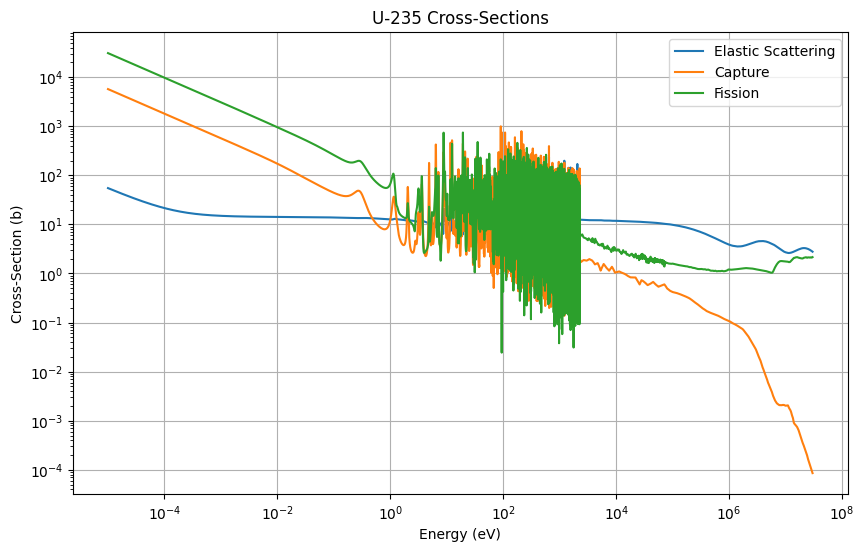

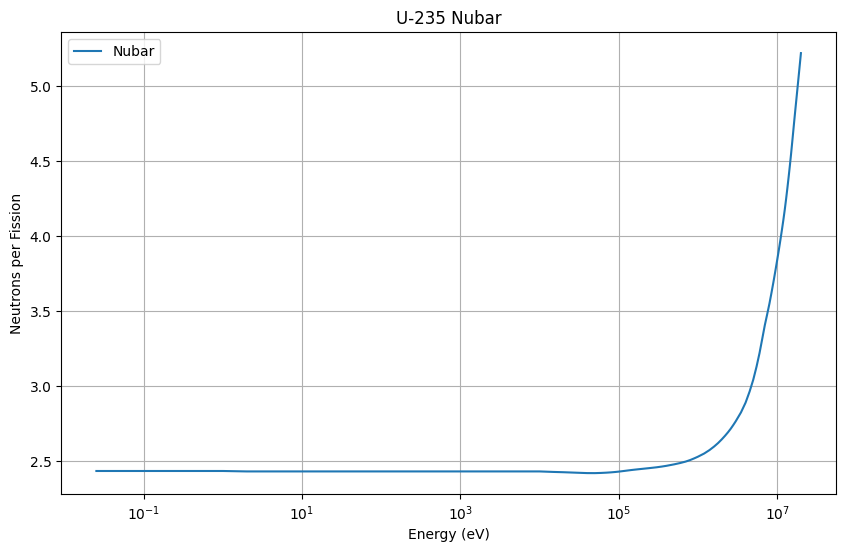

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load cross-section and nubar data
Es, xss = np.loadtxt('data/u235el.dat', skiprows=2).transpose()  # Elastic scattering
Ec, xsc = np.loadtxt('data/u235cap.dat', skiprows=2).transpose()  # Capture
Ef, xsf = np.loadtxt('data/u235fiss.dat', skiprows=2).transpose()  # Fission
Enu, nubar = np.loadtxt('data/u235nubar.dat', skiprows=2).transpose()  # Nubar

# Plot cross-sections
plt.figure(figsize=(10, 6))
plt.loglog(Es, xss, label='Elastic Scattering')
plt.loglog(Ec, xsc, label='Capture')
plt.loglog(Ef, xsf, label='Fission')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross-Section (b)')
plt.title('U-235 Cross-Sections')
plt.legend()
plt.grid(True)
plt.show()

# Plot nubar
plt.figure(figsize=(10, 6))
plt.semilogx(Enu, nubar, label='Nubar')
plt.xlabel('Energy (eV)')
plt.ylabel('Neutrons per Fission')
plt.title('U-235 Nubar')
plt.legend()
plt.grid(True)
plt.show()

Calculate Macroscopic Cross-Sections

In [6]:
density = 19.1  # g/cm³
A = 235  # Atomic mass of U-235
NA = 6.022e23  # Avogadro's number

# Convert microscopic cross-sections to macroscopic cross-sections
SigS = (density * NA / A) * xss  # Elastic scattering
SigC = (density * NA / A) * xsc  # Capture
SigF = (density * NA / A) * xsf  # Fission
SigT = SigS + SigC + SigF  # Total cross-section

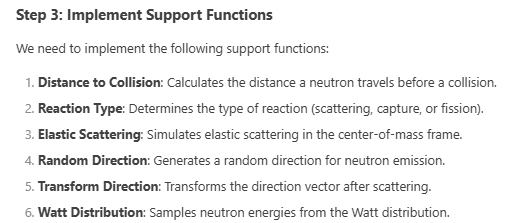

In [7]:
def distanceToCollision(SigT, N=1):
    """Calculate the distance to the next collision."""
    x = np.random.uniform(0, 1, N)
    return -np.log(x) / SigT

def reactionType(SigS, SigC, SigF, SigT):
    """Determine the type of reaction."""
    x = np.random.uniform(0, 1)
    if x < SigS / SigT:
        return 'scatter'
    elif x < (SigS + SigC) / SigT:
        return 'capture'
    else:
        return 'fission'

def elasticScatter(E):
    """Simulate elastic scattering."""
    muC = np.random.uniform(-1, 1)
    thetaC = np.arccos(muC)
    E = (((1 + alpha) + (1 - alpha) * muC) / 2) * E
    thetaL = np.arctan2(np.sin(thetaC), ((1 / A) + muC))
    muL = np.cos(thetaL)
    return E, muL

def randomDir():
    """Generate a random direction."""
    mu = np.random.uniform(-1, 1)
    theta = np.arccos(mu)
    phi = np.random.uniform(0, 2 * np.pi)
    u = np.sin(theta) * np.cos(phi)
    v = np.sin(theta) * np.sin(phi)
    w = np.cos(theta)
    return np.array([u, v, w])

def transformDir(u, v, w, mu):
    """Transform the direction vector after scattering."""
    phi = np.random.uniform(0, 2 * np.pi)
    un = mu * u + (np.sqrt(1 - mu**2) * (u * w * np.cos(phi) - v * np.sin(phi))) / np.sqrt(1 - w**2)
    vn = mu * v + (np.sqrt(1 - mu**2) * (v * w * np.cos(phi) + u * np.sin(phi))) / np.sqrt(1 - w**2)
    wn = mu * w - np.sqrt(1 - mu**2) * np.sqrt(1 - w**2) * np.cos(phi)
    return np.array([un, vn, wn])

def watt(x):
    """Watt distribution for fission neutron energies."""
    C1 = 0.453
    C2 = 0.965
    C3 = 2.29
    return C1 * np.exp(-x / C2) * np.sinh(np.sqrt(C3 * x))

def wattrnd(N):
    """Sample energies from the Watt distribution using rejection sampling."""
    energies = []
    while len(energies) < N:
        x = np.random.uniform(0, 10)  # Sample energy in MeV
        y = np.random.uniform(0, 0.5)  # Sample uniform value
        if y < watt(x):
            energies.append(x)
    return np.array(energies)

Step 4: Implement the run() Function
The run() function performs the Monte Carlo simulation for a given sphere radius (
R
R), number of generations (
N
G
E
N
NGEN), neutrons per generation (
N
P
G
NPG), and inactive generations (
N
S
K
I
P
NSKIP).

In [8]:
def run(R, NGEN, NPG, NSKIP):
    """Perform a criticality calculation in a U-235 sphere."""
    k_eff = []
    fission_sites = []

    for gen in range(NGEN):
        neutrons = []
        if gen < NSKIP:
            # Start neutrons from the center
            for _ in range(NPG):
                neutrons.append({'pos': np.array([0, 0, 0]), 'dir': randomDir(), 'E': 2.0})  # 2 MeV initial energy
        else:
            # Sample fission sites
            for _ in range(NPG):
                site = random.choice(fission_sites)
                neutrons.append({'pos': site['pos'], 'dir': randomDir(), 'E': wattrnd(1)[0]})

        # Track neutrons
        new_fission_sites = []
        for neutron in neutrons:
            while True:
                # Distance to collision
                d = distanceToCollision(SigT)
                # Update position
                neutron['pos'] += d * neutron['dir']
                # Check if neutron escapes
                if np.linalg.norm(neutron['pos']) > R:
                    break
                # Determine reaction type
                reaction = reactionType(SigS, SigC, SigF, SigT)
                if reaction == 'scatter':
                    neutron['E'], mu = elasticScatter(neutron['E'])
                    neutron['dir'] = transformDir(*neutron['dir'], mu)
                elif reaction == 'capture':
                    break
                elif reaction == 'fission':
                    new_fission_sites.append({'pos': neutron['pos']})
                    break

        # Update fission sites
        fission_sites = new_fission_sites
        # Estimate k_eff
        if gen >= NSKIP:
            k_eff.append(len(fission_sites) / NPG)

    # Calculate mean and standard deviation of k_eff
    keff = np.mean(k_eff)
    kstd = np.std(k_eff)
    return keff, kstd

 Run the Simulation and Analyze Results
Run the simulation for different sphere radii to find the critical radius where 
k
eff
≈
1
k 
eff
​
 ≈1.

k_eff = 0.7377 ± 0.0410
k_eff = 0.7343 ± 0.0402
R = 5.00 cm, k_eff = 0.7397
R = 6.11 cm, k_eff = 0.7362
R = 7.22 cm, k_eff = 0.7331
R = 8.33 cm, k_eff = 0.7356
R = 9.44 cm, k_eff = 0.7282
R = 10.56 cm, k_eff = 0.7373
R = 11.67 cm, k_eff = 0.7374
R = 12.78 cm, k_eff = 0.7383
R = 13.89 cm, k_eff = 0.7350
R = 15.00 cm, k_eff = 0.7456


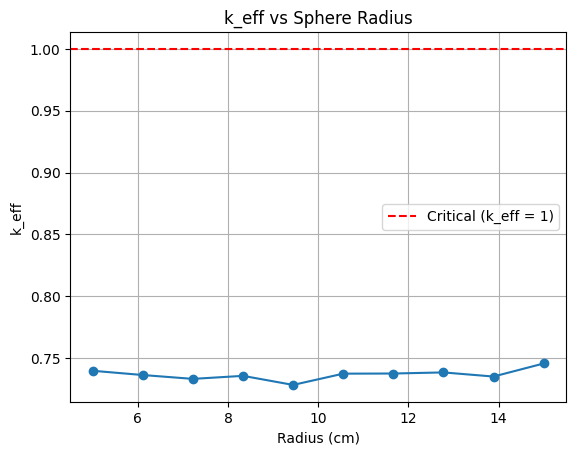

In [20]:
from scipy.interpolate import interp1d

# Interpolate cross-sections Interpolate Cross-Sections
#We need to interpolate the cross-sections to get the macroscopic cross-section at any given energy. We can use np.interp for this.
SigS_interp = interp1d(Es, SigS, kind='linear', fill_value="extrapolate")
SigC_interp = interp1d(Ec, SigC, kind='linear', fill_value="extrapolate")
SigF_interp = interp1d(Ef, SigF, kind='linear', fill_value="extrapolate")
SigT_interp = interp1d(Es, SigT, kind='linear', fill_value="extrapolate")

#The distanceToCollision function should now take the neutron's energy as input and return a single distance based on the interpolated cross-section.
def distanceToCollision(SigT_interp, E):
    """Calculate the distance to the next collision for a neutron with energy E."""
    SigT = SigT_interp(E)  # Get macroscopic cross-section at energy E
    x = np.random.uniform(0, 1)
    return -np.log(x) / SigT

#Similarly, the reactionType function should take the neutron's energy as input and use the interpolated cross-sections.
def reactionType(SigS_interp, SigC_interp, SigF_interp, SigT_interp, E):
    """Determine the type of reaction for a neutron with energy E."""
    SigS = SigS_interp(E)
    SigC = SigC_interp(E)
    SigF = SigF_interp(E)
    SigT = SigT_interp(E)
    x = np.random.uniform(0, 1)
    if x < SigS / SigT:
        return 'scatter'
    elif x < (SigS + SigC) / SigT:
        return 'capture'
    else:
        return 'fission'
    

#Now, update the run() function to use the interpolated cross-sections and the updated distanceToCollision and reactionType functions.
def run(R, NGEN, NPG, NSKIP):
    """Perform a criticality calculation in a U-235 sphere."""
    k_eff = []
    fission_sites = []

    for gen in range(NGEN):
        neutrons = []
        if gen < NSKIP:
            # Start neutrons from the center
            for _ in range(NPG):
                neutrons.append({'pos': np.array([0.0, 0.0, 0.0]), 'dir': randomDir(), 'E': 2.0})  # 2 MeV initial energy
        else:
            # Sample fission sites
            for _ in range(NPG):
                site = random.choice(fission_sites)
                neutrons.append({'pos': site['pos'], 'dir': randomDir(), 'E': wattrnd(1)[0]})

        # Track neutrons
        new_fission_sites = []
        for neutron in neutrons:
            while True:
                # Distance to collision
                d = distanceToCollision(SigT_interp, neutron['E'])
                # Update position
                neutron['pos'] += d * neutron['dir']
                # Check if neutron escapes
                if np.linalg.norm(neutron['pos']) > R:
                    break
                # Determine reaction type
                reaction = reactionType(SigS_interp, SigC_interp, SigF_interp, SigT_interp, neutron['E'])
                if reaction == 'scatter':
                    neutron['E'], mu = elasticScatter(neutron['E'])
                    neutron['dir'] = transformDir(*neutron['dir'], mu)
                elif reaction == 'capture':
                    break
                elif reaction == 'fission':
                    new_fission_sites.append({'pos': neutron['pos']})
                    break

        # Update fission sites
        fission_sites = new_fission_sites
        # Estimate k_eff
        if gen >= NSKIP:
            k_eff.append(len(fission_sites) / NPG)

    # Calculate mean and standard deviation of k_eff
    keff = np.mean(k_eff)
    kstd = np.std(k_eff)
    return keff, kstd



# Constants
density = 19.1  # g/cm³
A = 235  # Atomic mass of U-235
NA = 6.022e23  # Avogadro's number
alpha = ((A - 1) / (A + 1)) ** 2  # Elastic scattering parameter

keff, kstd = run(R, NGEN, NPG, NSKIP)
print(f"k_eff = {keff:.4f} ± {kstd:.4f}")


def elasticScatter(E):
    """Simulate elastic scattering."""
    muC = np.random.uniform(-1, 1)  # Cosine of scattering angle in CM frame
    thetaC = np.arccos(muC)  # Scattering angle in CM frame
    # Energy after scattering
    E = (((1 + alpha) + (1 - alpha) * muC) / 2) * E
    # Lab scattering angle
    thetaL = np.arctan2(np.sin(thetaC), ((1 / A) + muC))
    muL = np.cos(thetaL)  # Cosine of scattering angle in Lab frame
    return E, muL

#Now, test the updated simulation with the same parameters.
# Test the simulation 
R = 10  # Radius in cm
NGEN = 100  # Number of generations
NPG = 100  # Neutrons per generation
NSKIP = 10  # Inactive generations

keff, kstd = run(R, NGEN, NPG, NSKIP)
print(f"k_eff = {keff:.4f} ± {kstd:.4f}")





radii = np.linspace(5, 15, 10)  # Test radii from 5 cm to 15 cm
k_effs = []

for R in radii:
    keff, _ = run(R, NGEN, NPG, NSKIP)
    k_effs.append(keff)
    print(f"R = {R:.2f} cm, k_eff = {keff:.4f}")

# Plot k_eff vs radius
plt.plot(radii, k_effs, 'o-')
plt.axhline(1, color='red', linestyle='--', label='Critical (k_eff = 1)')
plt.xlabel('Radius (cm)')
plt.ylabel('k_eff')
plt.title('k_eff vs Sphere Radius')
plt.legend()
plt.grid(True)
plt.show()

Find the Critical Radius
Iterate over different radii to find the critical radius where 
k
eff
≈
1
k 
eff
​
 ≈1.

R = 5.00 cm, k_eff = 0.7343
R = 6.11 cm, k_eff = 0.7317
R = 7.22 cm, k_eff = 0.7348
R = 8.33 cm, k_eff = 0.7402
R = 9.44 cm, k_eff = 0.7350
R = 10.56 cm, k_eff = 0.7304
R = 11.67 cm, k_eff = 0.7263
R = 12.78 cm, k_eff = 0.7279
R = 13.89 cm, k_eff = 0.7316
R = 15.00 cm, k_eff = 0.7273


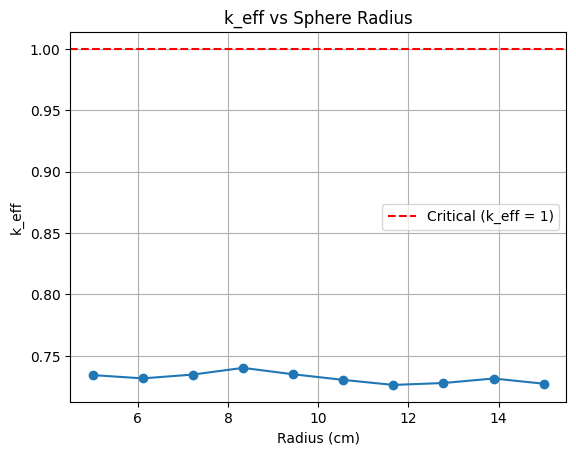

In [21]:
radii = np.linspace(5, 15, 10)  # Test radii from 5 cm to 15 cm
k_effs = []

for R in radii:
    keff, _ = run(R, NGEN, NPG, NSKIP)
    k_effs.append(keff)
    print(f"R = {R:.2f} cm, k_eff = {keff:.4f}")

# Plot k_eff vs radius
plt.plot(radii, k_effs, 'o-')
plt.axhline(1, color='red', linestyle='--', label='Critical (k_eff = 1)')
plt.xlabel('Radius (cm)')
plt.ylabel('k_eff')
plt.title('k_eff vs Sphere Radius')
plt.legend()
plt.grid(True)
plt.show()